In [1]:
#!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets

In [2]:
import os, sys
from os.path import abspath
import warnings

from __future__ import absolute_import, division, print_function, unicode_literals
import logging

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import keras.backend as k
from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping


# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()


np.random.seed(301)
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline

/data/pramodh/miniconda3/envs/cs776/lib/python3.9/site-packages/art/estimators/certification/__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")
2022-04-17 23:14:59.752113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Num GPUs Available:  3


2022-04-17 23:15:04.064394: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-17 23:15:04.066878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-17 23:15:04.119982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-17 23:15:04.121353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-17 23:15:04.123411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:0a:0

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [4]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [5]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [6]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 50000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

y_raw_unohv = np.argmax(y_raw, axis=1)
y_raw_test_unohv = np.argmax(y_raw_test, axis = 1)

In [7]:
x_train = x_raw
x_test = x_raw_test
y_train = y_raw
y_test = y_raw_test

In [8]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [9]:
# Poison training data
percent_poison = .05
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw_unohv, percent_poison, add_modification)
x_train_pois, y_train_pois = preprocess(x_poisoned_raw, y_poisoned_raw)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test_unohv, percent_poison, add_modification)
x_test_pois, y_test_pois = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)

# Shuffle training data
n_train_pois = np.shape(y_train_pois)[0]
shuffled_indices = np.arange(n_train_pois)
np.random.shuffle(shuffled_indices)
x_train_pois = x_train_pois[shuffled_indices]
y_train_pois = y_train_pois[shuffled_indices]
poison_x_test = x_test_pois[is_poison_test]
poison_y_test = y_test_pois[is_poison_test]
clean_x_test = x_test_pois[is_poison_test == 0]
clean_y_test = y_test_pois[is_poison_test == 0]

(50000, 32, 32, 3) x_clean shape
(5069, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5016, 32, 32, 3) src images shape
(257, 32, 32, 3) imgs to be poisoned shape
(4887, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5016, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5012, 32, 32, 3) src images shape
(263, 32, 32, 3) imgs to be poisoned shape
(5004, 32, 32, 3) src images shape
(266, 32, 32, 3) imgs to be poisoned shape
(5054, 32, 32, 3) src images shape
(261, 32, 32, 3) imgs to be poisoned shape
(4954, 32, 32, 3) src images shape
(261, 32, 32, 3) imgs to be poisoned shape
(4954, 32, 32, 3) src images shape
(265, 32, 32, 3) imgs to be poisoned shape
(5034, 32, 32, 3) src images shape
(267, 32, 32, 3) imgs to be poisoned shape
(52632, 32, 32, 3) x poison shape
(10000, 32, 32, 3) x_clean shape
(1000, 32, 32, 3) src images shape
(53, 32, 32, 3) imgs to be poisoned shape
(1000, 32, 32, 3) src images shape
(53, 32,

In [10]:
y_test_pois.shape

(10530, 10)

In [11]:
aug_pois = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug_pois.fit(x_train_pois)

In [12]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                            padding="same", kernel_initializer="he_normal")
        #self.conv_1 = Conv2D(16, (7, 7), strides=2,
        #                     padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
        #for res_block in [self.res_1_1, self.res_2_1, self.res_2_2, self.res_3_1, self.res_4_1, self.res_4_2]:
        #for res_block in [self.res_2_1, self.res_3_1, self.res_4_1]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [13]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
STEPS = len(x_train) / 256
history = model.fit_generator(aug_pois.flow(x_train_pois, y_train_pois, batch_size = 256), steps_per_epoch=STEPS, epochs=50, validation_data=(poison_x_test, poison_y_test), callbacks=[es])

Epoch 1/50


2022-04-17 23:15:37.582919: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-17 23:15:38.073707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-17 23:15:38.075465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-17 23:15:38.076819: I tensorflow/core/common_r

195/195 [==============================] - 62s 173ms/step - batch: 97.5000 - size: 255.4694 - loss: 1.6427 - accuracy: 0.3670 - val_loss: 3.1438 - val_accuracy: 0.0566
Epoch 2/50
195/195 [==============================] - 29s 148ms/step - batch: 97.5000 - size: 255.4694 - loss: 1.2691 - accuracy: 0.5636 - val_loss: 3.4653 - val_accuracy: 0.0491
Epoch 3/50
195/195 [==============================] - 30s 156ms/step - batch: 97.5000 - size: 255.4694 - loss: 1.1057 - accuracy: 0.6246 - val_loss: 3.2280 - val_accuracy: 0.0340
Epoch 4/50
195/195 [==============================] - 30s 155ms/step - batch: 97.5000 - size: 255.4694 - loss: 0.9876 - accuracy: 0.6670 - val_loss: 3.2510 - val_accuracy: 0.0434
Epoch 5/50
195/195 [==============================] - 30s 155ms/step - batch: 97.5000 - size: 255.4694 - loss: 0.8993 - accuracy: 0.6968 - val_loss: 2.7241 - val_accuracy: 0.1094
Epoch 6/50
195/195 [==============================] - 31s 158ms/step - batch: 97.5000 - size: 256.0000 - loss: 0.801

KeyboardInterrupt: 

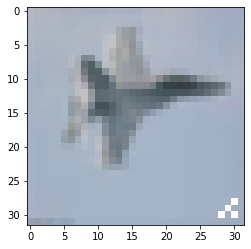

Prediction: 3

 Effectiveness of poison: 60.75%


In [15]:
poison_preds = np.argmax(model.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

c = 1 # class to display
i = 0 # image of the class to display

c_idx = 43

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

10000

Clean test set accuracy: 71.82%


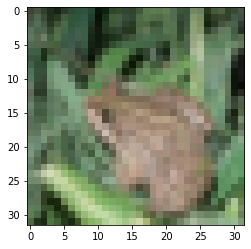

Prediction: 2


In [17]:
print(len(clean_x_test))
clean_preds = np.argmax(model.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = 4

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))